In [1]:
# ISLR material, Original R to Python adaptation by Jordi Warmenhoven
# Subsequent Adaptation from http://www.science.smith.edu/~jcrouser/SDS293/
# Further simplifications and adaptions done above those.

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import itertools
import time
import statsmodels.api as sm
import matplotlib.pyplot as plt

C:\Apps\Dir\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Best Subset Selection

In [3]:
hitters_df = pd.read_csv('Hitters.csv')
hitters_df.head()

,Player,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,-Andy Allanson,293,66,1,30,29,14,1,293,66,...,30,29,14,A,E,446,33,20,NaN,A
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.0,N
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,480.0,A
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,500.0,N
4,-Andres Galarraga,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,91.5,N


In [4]:
print("Number of null values:", hitters_df["Salary"].isnull().sum())

Number of null values: 59


In [5]:
print("Dimensions of original data:", hitters_df.shape)
hitters_df_clean = hitters_df.dropna().drop('Player', axis=1)
print("Dimensions of modified data:", hitters_df_clean.shape)
print("Number of null values:", hitters_df_clean["Salary"].isnull().sum())

Dimensions of original data: (322, 21)
Dimensions of modified data: (263, 20)
Number of null values: 0


In [6]:
dummies = pd.get_dummies(hitters_df_clean[['League', 'Division', 'NewLeague']])
y = hitters_df_clean.Salary
X_ = hitters_df_clean.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)

In [7]:
def processSubset(feature_set):
    model = sm.OLS(y,X[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X[list(feature_set)]) - y) ** 2).sum()
    return {"model":regr, "RSS":RSS}

In [8]:
def getBest(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset(combo))
    models = pd.DataFrame(results)
    best_model = models.loc[models['RSS'].idxmin()]
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    return best_model

In [9]:
models_best = pd.DataFrame(columns=["RSS", "model"])
tic = time.time()
for i in range(1,6):
    models_best.loc[i] = getBest(i)
toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed 19 models on 1 predictors in 0.32760071754455566 seconds.
Processed 171 models on 2 predictors in 0.858001708984375 seconds.
Processed 969 models on 3 predictors in 4.882808685302734 seconds.
Processed 3876 models on 4 predictors in 23.566041231155396 seconds.
Processed 11628 models on 5 predictors in 142.2680275440216 seconds.
Total elapsed time: 171.96487951278687 seconds.


In [10]:
models_best

,RSS,model
1,4.321393e+07,<statsmodels.regression.linear_model.Regressio...
2,3.073305e+07,<statsmodels.regression.linear_model.Regressio...
3,2.941071e+07,<statsmodels.regression.linear_model.Regressio...
4,2.797678e+07,<statsmodels.regression.linear_model.Regressio...
5,2.718780e+07,<statsmodels.regression.linear_model.Regressio...


In [11]:
print(models_best.loc[2, "model"].summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     416.7
Date:                Sat, 19 May 2018   Prob (F-statistic):           5.80e-82
Time:                        19:11:00   Log-Likelihood:                -1907.6
No. Observations:                 263   AIC:                             3819.
Df Residuals:                     261   BIC:                             3826.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Hits           2.9538      0.261     11.335      0.0

In [12]:
print(getBest(19)["model"].summary())

Processed 1 models on 19 predictors in 0.062399864196777344 seconds.
                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     54.64
Date:                Sat, 19 May 2018   Prob (F-statistic):           1.31e-76
Time:                        19:11:01   Log-Likelihood:                -1877.9
No. Observations:                 263   AIC:                             3794.
Df Residuals:                     244   BIC:                             3862.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

In [13]:
models_best.loc[2, "model"].rsquared

0.7614950002332872

In [14]:
models_best.apply(lambda row: row[1].rsquared, axis=1)

1    0.664637
2    0.761495
3    0.771757
4    0.782885
5    0.789008
dtype: float64

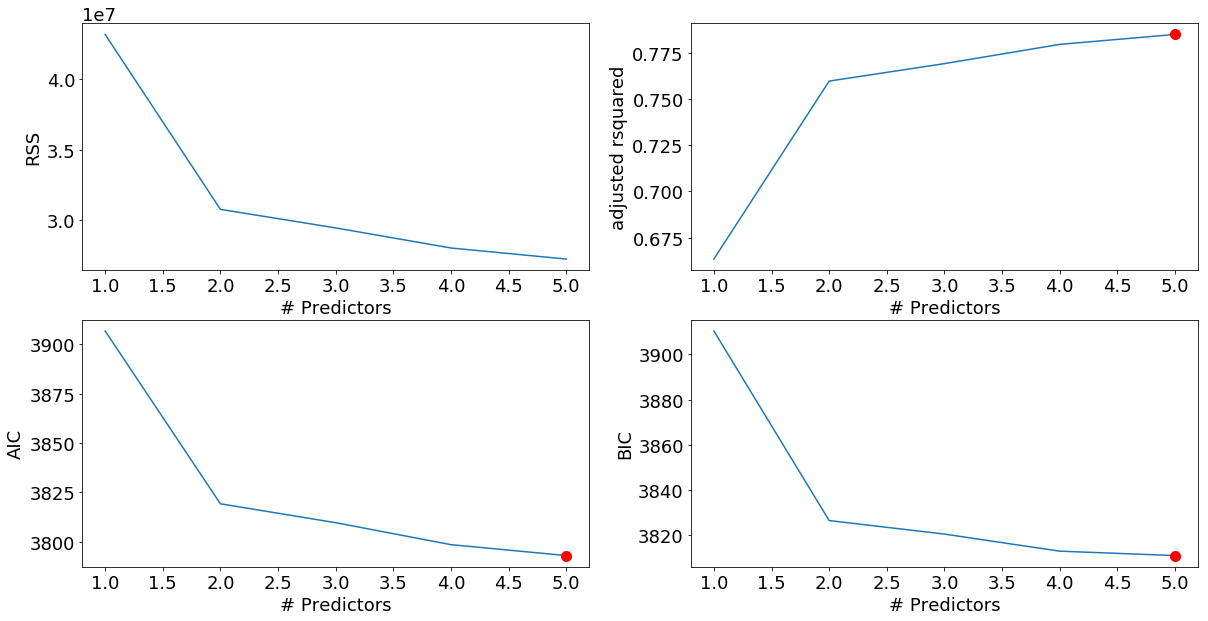

In [15]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

plt.subplot(2, 2, 1)
plt.plot(models_best["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')
rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.idxmax(), rsquared_adj.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')
aic = models_best.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.idxmin(), aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')
bic = models_best.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.idxmin(), bic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('BIC')
plt.show()

### Forward and Backward Stepwise Selection

In [16]:
def forward(predictors):
    remaining_predictors = [p for p in X.columns if p not in predictors]
    tic = time.time()
    results = []
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    models = pd.DataFrame(results)
    best_model = models.loc[models['RSS'].idxmin()]
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    return best_model

In [17]:
models_fwd = pd.DataFrame(columns=["RSS", "model"])
tic = time.time()
predictors = []
for i in range(1,len(X.columns)+1):    
    models_fwd.loc[i] = forward(predictors)
    predictors = models_fwd.loc[i]["model"].model.exog_names
toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed  19 models on 1 predictors in 2.714405059814453 seconds.
Processed  18 models on 2 predictors in 0.3120005130767822 seconds.
Processed  17 models on 3 predictors in 0.07799983024597168 seconds.
Processed  16 models on 4 predictors in 0.10920023918151855 seconds.
Processed  15 models on 5 predictors in 0.09360027313232422 seconds.
Processed  14 models on 6 predictors in 0.10920000076293945 seconds.
Processed  13 models on 7 predictors in 0.12480020523071289 seconds.
Processed  12 models on 8 predictors in 0.07799983024597168 seconds.
Processed  11 models on 9 predictors in 0.062400102615356445 seconds.
Processed  10 models on 10 predictors in 0.07800006866455078 seconds.
Processed  9 models on 11 predictors in 0.14040017127990723 seconds.
Processed  8 models on 12 predictors in 0.062400102615356445 seconds.
Processed  7 models on 13 predictors in 0.04680013656616211 seconds.
Processed  6 models on 14 predictors in 0.062400102615356445 seconds.
Processed  5 models on 15 predict

In [18]:
print(models_fwd.loc[1, "model"].summary())
print(models_fwd.loc[2, "model"].summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     519.2
Date:                Sat, 19 May 2018   Prob (F-statistic):           4.20e-64
Time:                        19:11:07   Log-Likelihood:                -1952.4
No. Observations:                 263   AIC:                             3907.
Df Residuals:                     262   BIC:                             3910.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Hits           4.8833      0.214     22.787      0.0

In [19]:
print(models_best.loc[5, "model"].summary())
print(models_fwd.loc[5, "model"].summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     193.0
Date:                Sat, 19 May 2018   Prob (F-statistic):           5.32e-85
Time:                        19:11:07   Log-Likelihood:                -1891.5
No. Observations:                 263   AIC:                             3793.
Df Residuals:                     258   BIC:                             3811.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
AtBat         -1.9281      0.463     -4.166      0.0

### Backward Selection

In [20]:
def backward(predictors):
    tic = time.time()
    results = []
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(combo))
    models = pd.DataFrame(results)
    best_model = models.loc[models['RSS'].idxmin()]
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)-1, "predictors in", (toc-tic), "seconds.")
    return best_model

In [21]:
models_bwd = pd.DataFrame(columns=["RSS", "model"], index = range(1,len(X.columns)))
tic = time.time()
predictors = X.columns
while(len(predictors) > 1):  
    models_bwd.loc[len(predictors)-1] = backward(predictors)
    predictors = models_bwd.loc[len(predictors)-1]["model"].model.exog_names
toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed  19 models on 18 predictors in 0.218400239944458 seconds.
Processed  18 models on 17 predictors in 0.14039993286132812 seconds.
Processed  17 models on 16 predictors in 0.18720054626464844 seconds.
Processed  16 models on 15 predictors in 0.12480020523071289 seconds.
Processed  15 models on 14 predictors in 0.18720054626464844 seconds.
Processed  14 models on 13 predictors in 0.09360027313232422 seconds.
Processed  13 models on 12 predictors in 0.4680008888244629 seconds.
Processed  12 models on 11 predictors in 0.062400102615356445 seconds.
Processed  11 models on 10 predictors in 0.09360027313232422 seconds.
Processed  10 models on 9 predictors in 0.0905001163482666 seconds.
Processed  9 models on 8 predictors in 0.062400102615356445 seconds.
Processed  8 models on 7 predictors in 0.04680013656616211 seconds.
Processed  7 models on 6 predictors in 0.04679989814758301 seconds.
Processed  6 models on 5 predictors in 0.06240034103393555 seconds.
Processed  5 models on 4 predic

In [22]:
print("Best Subset:")
print(models_best.loc[5, "model"].params)

Best Subset:
AtBat     -1.928099
Hits       7.975733
Walks      3.912872
CRBI       0.645349
PutOuts    0.266424
dtype: float64


In [23]:
print("Foward Selection:")
print(models_fwd.loc[5, "model"].params)

Foward Selection:
Hits            6.542622
CRBI            0.701100
Division_W   -110.052466
PutOuts         0.297317
AtBat          -1.091528
dtype: float64


In [24]:
print("Backward Selection:")
print(models_bwd.loc[5, "model"].params)

Backward Selection:
AtBat     -1.899448
Hits       7.754626
Walks      3.687280
CRuns      0.624463
PutOuts    0.301334
dtype: float64
